In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    r2_score,           
    confusion_matrix,   
    accuracy_score,     
    roc_curve,          
    roc_auc_score 
)

DATASET_NAME = 'Credit Card Fraud Detection Dataset 2023'
FILE_NAME = 'creditcard_2023.csv'
TOTAL_SAMPLES = 568630

## 📝 Project Description Document: General Information on Dataset (a.)

**a. General Information on dataset:**

1.  **Name of dataset used:** Credit Card Fraud Detection Dataset 2023 (`creditcard_2023.csv`)
2.  **Number of classes and their labels:** 2 classes. **Label 0** (Non-Fraudulent Transaction) and **Label 1** (Fraudulent Transaction).
3.  **Total number of samples in dataset:** 568,630
4.  **Size of each sample:** Not applicable (tabular data). The input vector dimension is 29.
5.  **Number of samples used in training, validation and testing (60/20/20 split):** (Sizes will be calculated in the next cell)

In [2]:
Data = pd.read_csv(FILE_NAME)
    
# Separate features (X) and target (y). Drop 'id' column.
X = Data.drop(['id', 'Class'], axis=1)
y = Data['Class']

# 1. Split into temporary set (Train+Validation) and Test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Split temporary set into Train (60% of total) and Validation (20% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

TRAIN_SIZE = X_train_scaled.shape[0]
VAL_SIZE = X_val_scaled.shape[0]
TEST_SIZE = X_test_scaled.shape[0]

print(f"Data split and scaled:")
print(f"  Training Set (60%): {TRAIN_SIZE} samples")
print(f"  Validation Set (20%): {VAL_SIZE} samples")
print(f"  Testing Set (20%): {TEST_SIZE} samples")

Data split and scaled:
  Training Set (60%): 341178 samples
  Validation Set (20%): 113726 samples
  Testing Set (20%): 113726 samples


## ⚙️ Project Description Document: Implementation details (b.)

**b. Implementation details:**

1.  **At feature extraction phase:**
    * **Features extracted:** 29 features (`V1` through `V28` and `Amount`).
    * **Dimension of resulted features (input vector):** 29 dimensions. (Features were scaled using StandardScaler).

2.  **Is cross-validation is used?** **No.** A dedicated 20% Validation Set is used for loss monitoring and early stopping instead of K-Fold cross-validation.

3.  **Hyperparameters used in your model (SGDRegressor - Linear Regression):**
    * **Model:** $\mathbf{sklearn.linear\_model.SGDRegressor}$
    * **Optimizer:** Stochastic Gradient Descent (SGD)
    * **Loss Function:** $\mathbf{'squared\_error'}$ (Mean Squared Error, implementing Linear Regression)
    * **Initial Learning Rate ($\mathbf{\eta_0}$):** 0.01
    * **Regularization ($\mathbf{penalty}$):** 'l2' (Ridge regularization, $\mathbf{alpha=0.0001}$)
    * **No. of Epochs:** Training is limited by **Early Stopping** based on validation loss, with a maximum of 50 epochs.

In [3]:
# Hyperparameters for training
max_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_epoch = 0

# Initialize SGDRegressor (Linear Regression)
model = SGDRegressor(
    loss='squared_error',
    penalty='l2',
    alpha=0.0001,
    eta0=0.01,
    learning_rate='constant',
    max_iter=1000,
    random_state=42,
    warm_start=True, # Retain weights from previous fit call
    shuffle=False
)

training_losses = []
validation_losses = []

print("Starting training with Early Stopping...")

# Training loop with Early Stopping
for epoch in range(max_epochs):
    model.fit(X_train_scaled, y_train)
    
    # Calculate Training Loss (MSE)
    y_train_pred = model.predict(X_train_scaled)
    train_loss = mean_squared_error(y_train, y_train_pred)
    training_losses.append(train_loss)
    
    # Calculate Validation Loss (MSE)
    y_val_pred = model.predict(X_val_scaled)
    val_loss = mean_squared_error(y_val, y_val_pred)
    validation_losses.append(val_loss)
    
    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_epoch = epoch + 1
    else:
        epochs_no_improve += 1
        
    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered at Epoch {epoch + 1}.")
        break
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{max_epochs}, Train MSE: {train_loss:.6f}, Val MSE: {val_loss:.6f}")

print(f"\nTraining stopped. Best model epoch: {best_epoch} with Val MSE: {best_val_loss:.6f}")

Starting training with Early Stopping...

Early stopping triggered at Epoch 6.

Training stopped. Best model epoch: 1 with Val MSE: 0.103400


## 📊 Project Description Document: Results details (c.)

***NOTE: Results below will be computed on the Testing Data.***

The Linear Regression model outputs a continuous value. To obtain the requested classification metrics (Accuracy, Confusion Matrix, ROC), the continuous output ($\mathbf{y_{pred\_cont}}$) is **binarized** using a threshold of **$\mathbf{0.5}$** on the test set.

* $\mathbf{y_{pred\_bin}} = 1$ if $\mathbf{y_{pred\_cont} \ge 0.5}$, else $\mathbf{0}$.

In [4]:
# Continuous predictions (Used for MSE, R2, and ROC AUC)
y_pred_cont = model.predict(X_test_scaled) 

# Binarize continuous predictions (Used for Accuracy, Confusion Matrix)
THRESHOLD = 0.5
y_pred_bin = (y_pred_cont >= THRESHOLD).astype(int)

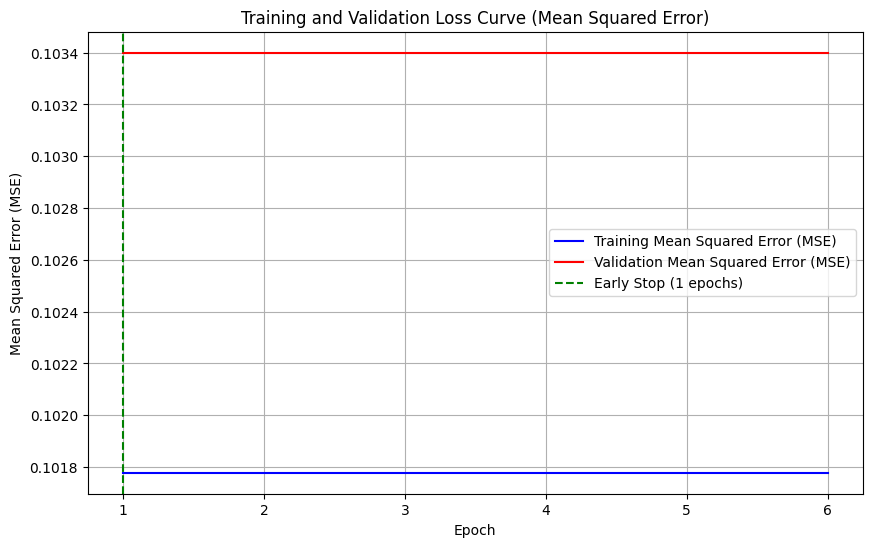

In [5]:
# Loss Curve (Mean Squared Error)
epochs_plot = range(1, len(training_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_plot, training_losses, label='Training Mean Squared Error (MSE)', color='b')
plt.plot(epochs_plot, validation_losses, label='Validation Mean Squared Error (MSE)', color='r')
if best_epoch > 0:
    plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Early Stop ({best_epoch} epochs)')
plt.title('Training and Validation Loss Curve (Mean Squared Error)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
test_mse = mean_squared_error(y_test, y_pred_cont)
test_r2 = r2_score(y_test, y_pred_cont)
accuracy = accuracy_score(y_test, y_pred_bin)
auc = roc_auc_score(y_test, y_pred_cont)

print(f"\n--- Testing Data Results ---")
print(f"Test Set Accuracy (using 0.5 threshold): {accuracy:.4f}")
print(f"Test Set Mean Squared Error (MSE): {test_mse:.6f}")
print(f"Test Set R-squared (R²): {test_r2:.4f}")
print(f"Test Set AUC: {auc:.4f}")


--- Testing Data Results ---
Test Set Accuracy (using 0.5 threshold): 0.9152
Test Set Mean Squared Error (MSE): 0.102807
Test Set R-squared (R²): 0.5888
Test Set AUC: 0.9585


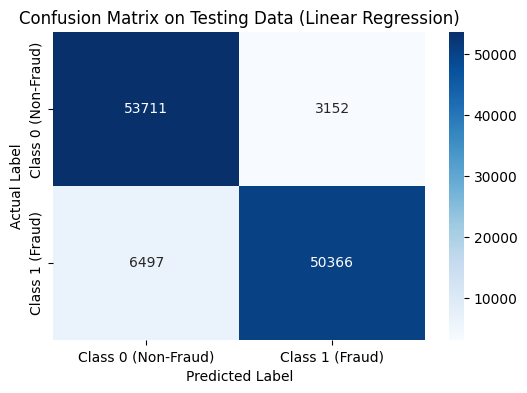

In [7]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_bin)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0 (Non-Fraud)', 'Class 1 (Fraud)'], yticklabels=['Class 0 (Non-Fraud)', 'Class 1 (Fraud)'])
plt.title('Confusion Matrix on Testing Data (Linear Regression)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

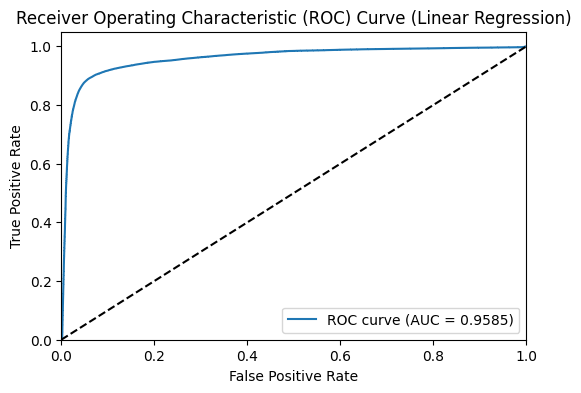

In [8]:
# ROC curve 
fpr, tpr, _ = roc_curve(y_test, y_pred_cont)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Linear Regression)')
plt.legend(loc="lower right")
plt.show()